In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, pi
import cv2

from pyfishsense import WorldPointHandler
from pyfishsense.library.constants import PIXEL_PITCH_MM

In [2]:
lens_calibration_path = Path("../demo/data/lens-calibration.pkg")
laser_calibration_path = Path("../demo/data/laser-calibration.pkg")

In [3]:
world_point_handler = WorldPointHandler(lens_calibration_path, laser_calibration_path)

print(world_point_handler.laser_orientation)
print(world_point_handler.laser_position)

laser_orientation = np.array([0, 0, 1])
laser_position = np.array([-0.3, -0.1, 0])

world_point_handler.laser_orientation = laser_orientation
world_point_handler.laser_position = laser_position

[0.00877752 0.04130509 0.99910793]
[-0.02991158 -0.09781963  0.        ]


In [4]:
def get_laser_projection(laser_orientation, laser_position, dist):
    focal_length_mm = world_point_handler.calibration_matrix[0][0] * PIXEL_PITCH_MM

    plane_normal = np.array([0, 0, 1])
    plane_origin = np.array([0, 0, dist])

    laser_scalar = np.dot((plane_origin - laser_position), plane_normal) / np.dot(
        laser_orientation, plane_normal
    )
    # laser_scalar2 = float(dist) / laser_orientation[2]
    laser_dot = laser_position + laser_orientation * laser_scalar

    # world_point_handler.calibration_matrix[1][1] = world_point_handler.calibration_matrix[0][0]
    dist_coeffs = np.zeros((5, 1), np.float32) 
    laser_projection = cv2.projectPoints(laser_dot[None, None, :], np.eye(3), np.zeros((3, 1)), world_point_handler.calibration_matrix, dist_coeffs)

    return laser_projection

In [5]:
results = {}

for i in range(10):
    dist = float(i) / 2 + 0.5
    i_result = []

    for j in range(199):
        angle = 90 - float(j) / 100

        laser_orientation = np.array([cos(angle * pi / 180), 0, sin(angle * pi / 180)])

        # laser_orientation = world_point_handler.laser_orientation
        # laser_position = world_point_handler.laser_position

        i_result.append(world_point_handler.calculate_laser_parallax(get_laser_projection(laser_orientation, laser_position, dist)[0][0, 0, :])[2])

    results[dist] = np.array(i_result)

In [6]:
x = (np.arange(199, dtype=float)) / 100
x

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

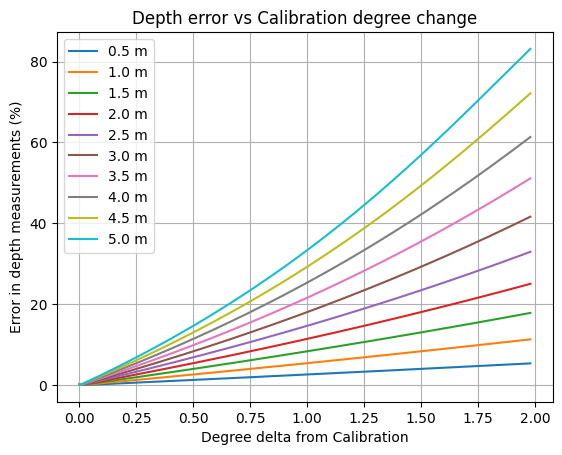

In [7]:
for i in range(10):
    dist = float(i) / 2 + 0.5

    # if dist != 1:
    #     continue

    plt.plot(x, abs(dist - results[dist]) / dist * 100, label=f"{dist} m")
    # plt.plot(x, results[dist], label=f"{dist} m")

plt.legend()
plt.xlabel("Degree delta from Calibration")
plt.ylabel("Error in depth measurements (%)")
plt.title("Depth error vs Calibration degree change")
plt.grid()

In [8]:
# Adapted from https://gist.github.com/fasiha/6c331b158d4c40509bd180c5e64f7924#file-rotatevectors-py-L35-L42
def makeUnit(x):
    """Normalize entire input to norm 1. Not what you want for 2D arrays!"""
    return x / np.linalg.norm(x)

def xParV(x, v):
    """Project x onto v. Result will be parallel to v."""
    # (x' * v / norm(v)) * v / norm(v)
    # = (x' * v) * v / norm(v)^2
    # = (x' * v) * v / (v' * v)
    return np.dot(x, v) / np.dot(v, v) * v

def xProjectV(x, v):
    """Project x onto v, returning parallel and perpendicular components
    >> d = xProject(x, v)
    >> np.allclose(d['par'] + d['perp'], x)
    True
    """
    par = xParV(x, v)
    perp = x - par
    return {'par': par, 'perp': perp}


def rotateAbout(a, b, theta):
    """Rotate vector a about vector b by theta radians."""
    # Thanks user MNKY at http://math.stackexchange.com/a/1432182/81266
    proj = xProjectV(a, b)
    w = np.cross(b, proj['perp'])
    return (proj['par'] +
            proj['perp'] * np.cos(theta) +
            np.linalg.norm(proj['perp']) * makeUnit(w) * np.sin(theta))

In [9]:
def get_rotated_laser_orientation(theta, fi):
    theta_prime = float(90 - theta)
    laser_orientation = np.array([cos(theta_prime * pi / 180), 0, sin(theta_prime * pi / 180)])
    return rotateAbout(
        laser_orientation,
        np.array([0, 0, 1]),
        float(fi) * pi / 180)

In [10]:
results = {}
laser_position = np.array([-0.3, -0.1, 0])
world_point_handler.laser_position = laser_position

for i in range(11):
    theta = float(i) / 2
    i_result = []

    # if theta != 5:
    #     continue

    world_point_handler.laser_orientation = get_rotated_laser_orientation(theta, 0)

    for fi in range(400):
        # if fi != 0:
        #     continue

        laser_orientation = get_rotated_laser_orientation(theta, fi)
        i_result.append(world_point_handler.calculate_laser_parallax(get_laser_projection(laser_orientation, laser_position, 3)[0][0, 0, :])[2])

        # if fi == 0:
        #     print(get_laser_projection(laser_orientation, laser_position, 3))

    results[theta] = np.array(i_result)

In [11]:
x = (np.arange(400, dtype=float))
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

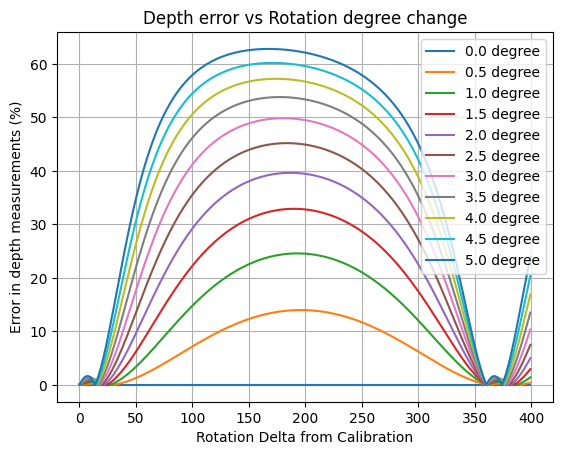

In [12]:
for i in range(11):
    angle = float(i) / 2

    # if angle != 5:
    #     continue

    plt.plot(x, abs(3 - results[angle]) / 3 * 100, label=f"{angle} degree")
    # plt.plot(x, results[angle], label=f"{angle} degree")

plt.legend()
plt.xlabel("Rotation Delta from Calibration")
plt.ylabel("Error in depth measurements (%)")
plt.title("Depth error vs Rotation degree change")
plt.grid()

In [13]:
# get_rotated_laser_orientation(theta, 0)